In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt

# visualizations
import seaborn as sns
sns.set_style('whitegrid')


# Load the dataset
df = pd.read_csv('Customer_Personality_Segmentation.csv', sep='\t')

# Examine the first few rows
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [43]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Data types check
print("\nData types:")
print(df.dtypes)

# Handle missing values - drop rows with missing Income (24 rows per screenshot)
df_clean = df.dropna().copy()
df_clean['Dt_Customer'] = pd.to_datetime(df_clean['Dt_Customer'], format='%d-%m-%Y')

# Convert Dt_Customer to datetime format
df_clean['Dt_Customer'] = pd.to_datetime(df_clean['Dt_Customer'], format='%d-%m-%Y')

# Create Age feature
current_year = 2025
df_clean['Age'] = current_year - df_clean['Year_Birth']

# Calculate total spending across all product categories
spend_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_clean['TotalSpend'] = df_clean[spend_cols].sum(axis=1)

# Calculate number of children in household
df_clean['Children'] = df_clean['Kidhome'] + df_clean['Teenhome']

# Check for outliers in Age (looking at your dataset, there appear to be some very old customers)
print("\nAge statistics:")
print(df_clean['Age'].describe())


Missing values per column:
Income    24
dtype: int64

Data types:
ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

Age statistics:
coun

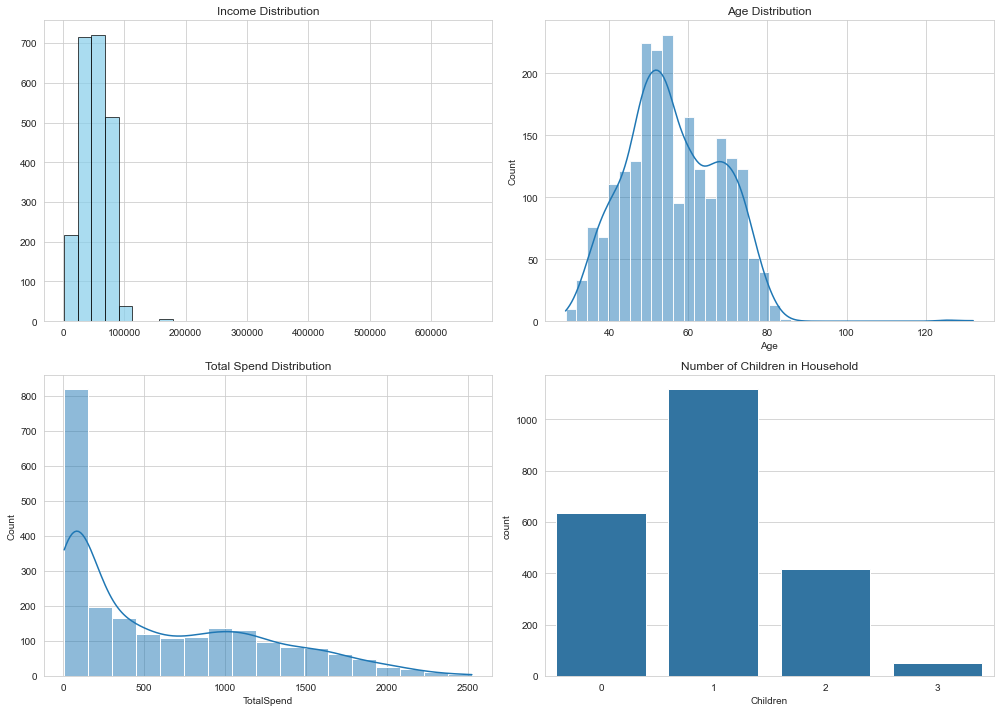

In [4]:
# Distributions of key variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Income distribution
axes[0, 0].hist(df_clean['Income'].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Income Distribution')


# Age distribution
sns.histplot(df_clean['Age'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution')

# Total spend distribution
sns.histplot(df_clean['TotalSpend'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Total Spend Distribution')

# Number of children
sns.countplot(x=df_clean['Children'], ax=axes[1, 1])
axes[1, 1].set_title('Number of Children in Household')

plt.tight_layout()
plt.show()


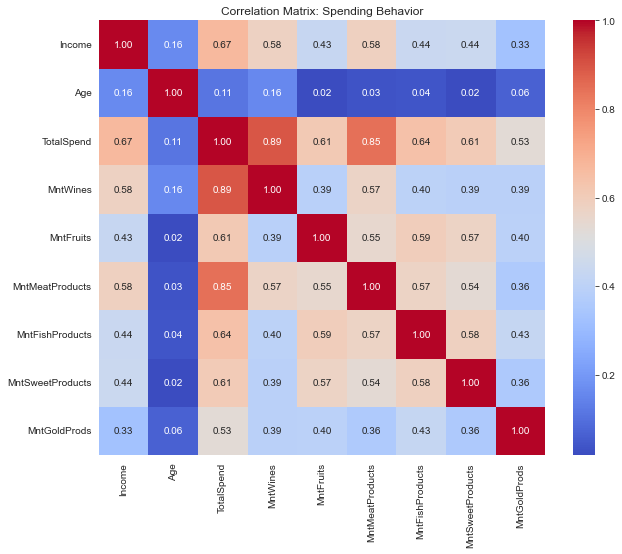

In [5]:
# Correlation matrix of spending behavior, income, and age
spend_corr = df_clean[['Income', 'Age', 'TotalSpend'] + spend_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(spend_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Spending Behavior')
plt.show()



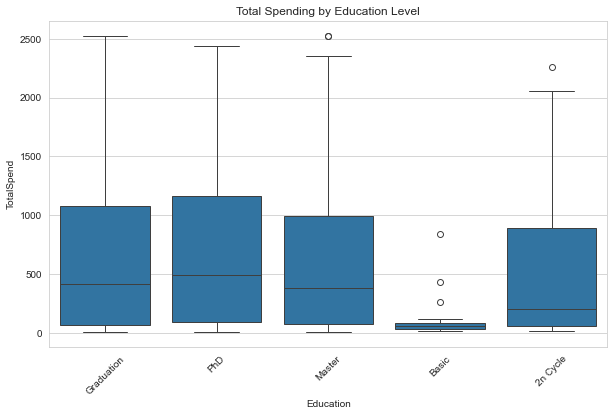

In [6]:
# Spending by education level
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education', y='TotalSpend', data=df_clean)
plt.title('Total Spending by Education Level')
plt.xticks(rotation=45)
plt.show()



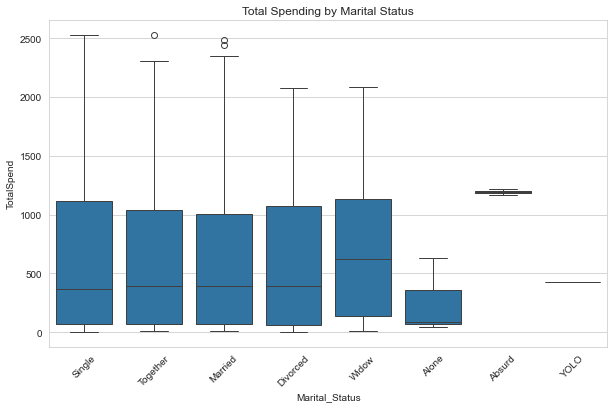

In [7]:
# Spending by marital status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Marital_Status', y='TotalSpend', data=df_clean)
plt.title('Total Spending by Marital Status')
plt.xticks(rotation=45)
plt.show()

In [8]:
# Feature engineering
# Create feature for campaign response rate
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
df_clean['CampaignAcceptance'] = df_clean[campaign_cols].sum(axis=1)

In [9]:
# Create feature for purchasing channels preference
df_clean['WebPurchaseRatio'] = df_clean['NumWebPurchases'] / (df_clean['NumStorePurchases'] + df_clean['NumCatalogPurchases'] + df_clean['NumWebPurchases'])
df_clean['StorePurchaseRatio'] = df_clean['NumStorePurchases'] / (df_clean['NumStorePurchases'] + df_clean['NumCatalogPurchases'] + df_clean['NumWebPurchases'])
df_clean['CatalogPurchaseRatio'] = df_clean['NumCatalogPurchases'] / (df_clean['NumStorePurchases'] + df_clean['NumCatalogPurchases'] + df_clean['NumWebPurchases'])

In [10]:
# Handle potential division by zero by filling NaN values
df_clean[['WebPurchaseRatio', 'StorePurchaseRatio', 'CatalogPurchaseRatio']] = df_clean[['WebPurchaseRatio', 'StorePurchaseRatio', 'CatalogPurchaseRatio']].fillna(0)

In [11]:
# Calculate tenure in years
df_clean['Tenure'] = (pd.to_datetime('2025-01-01') - df_clean['Dt_Customer']).dt.days / 365.25

In [12]:
# Create spending categories ratios
df_clean['WineRatio'] = df_clean['MntWines'] / df_clean['TotalSpend']
df_clean['MeatRatio'] = df_clean['MntMeatProducts'] / df_clean['TotalSpend']
df_clean['GoldRatio'] = df_clean['MntGoldProds'] / df_clean['TotalSpend']

In [13]:
# Fill NaNs from divisions by zero
df_clean[['WineRatio', 'MeatRatio', 'GoldRatio']] = df_clean[['WineRatio', 'MeatRatio', 'GoldRatio']].fillna(0)

In [14]:
#Customer segmentation with K-means

# Select relevant features for clustering
features = [
    'Age', 'Income', 'TotalSpend', 'Children', 'Recency', 'CampaignAcceptance',
    'WebPurchaseRatio', 'StorePurchaseRatio', 'NumWebVisitsMonth', 'Tenure'
]

In [15]:
# Create a copy of selected features for clustering
X = df_clean[features].copy()

In [16]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Determine optimal number of clusters using Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

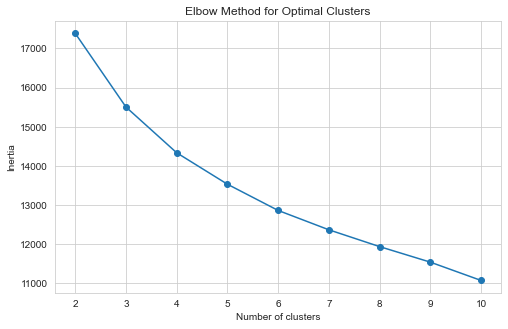

In [21]:
# Plot the Elbow Method results
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [23]:
# Implement K-Means with 4 clusters (based on elbow plot analysis)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

In [24]:
# Analyze segments
cluster_summary = df_clean.groupby('Cluster')[features + ['TotalSpend']].mean()
print("Cluster Centers:")
print(cluster_summary)

Cluster Centers:
               Age        Income   TotalSpend  Children    Recency  \
Cluster                                                              
0        47.825431  29853.334052    93.931034  0.950431  42.887931   
1        57.184669  77570.909408  1383.432056  0.191638  49.320557   
2        61.493601  51321.179159   353.879342  1.462523  54.349177   
3        56.801902  46481.101426   497.675119  1.185420  48.610143   

         CampaignAcceptance  WebPurchaseRatio  StorePurchaseRatio  \
Cluster                                                             
0                  0.148707          0.292813            0.654216   
1                  1.071429          0.256359            0.425982   
2                  0.111517          0.300859            0.573294   
3                  0.394612          0.445739            0.403040   

         NumWebVisitsMonth     Tenure   TotalSpend  
Cluster                                             
0                 6.592672  11.502685    

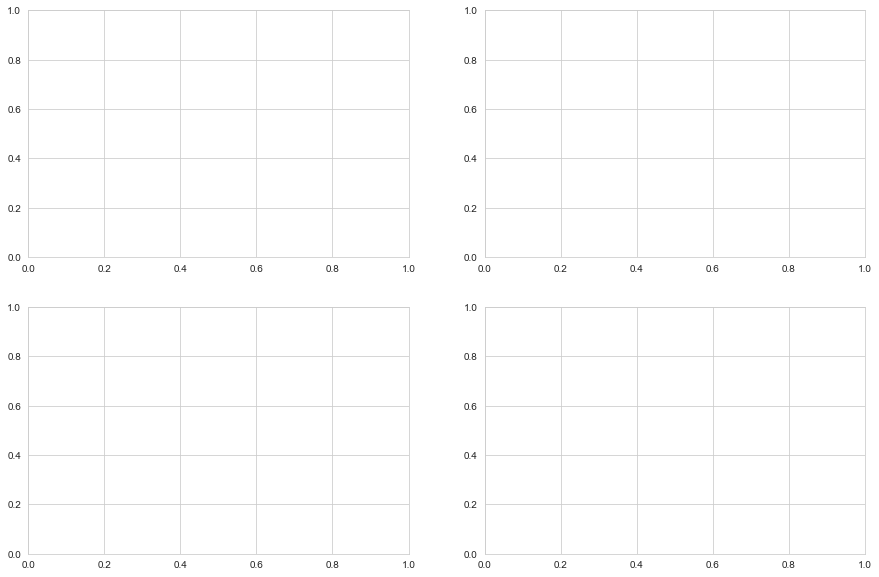

In [25]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

In [26]:
# Income by cluster
sns.boxplot(x='Cluster', y='Income', data=df_clean, ax=axes[0, 0])
axes[0, 0].set_title('Income Distribution by Cluster')

Text(0.5, 1.0, 'Income Distribution by Cluster')

In [27]:
# Age by cluster
sns.boxplot(x='Cluster', y='Age', data=df_clean, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Cluster')

Text(0.5, 1.0, 'Age Distribution by Cluster')

In [28]:
# Total spending by cluster
sns.boxplot(x='Cluster', y='TotalSpend', data=df_clean, ax=axes[1, 0])
axes[1, 0].set_title('Total Spending by Cluster')

Text(0.5, 1.0, 'Total Spending by Cluster')

In [29]:
# Campaign acceptance by cluster
sns.boxplot(x='Cluster', y='CampaignAcceptance', data=df_clean, ax=axes[1, 1])
axes[1, 1].set_title('Campaign Responses by Cluster')

Text(0.5, 1.0, 'Campaign Responses by Cluster')

In [30]:
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

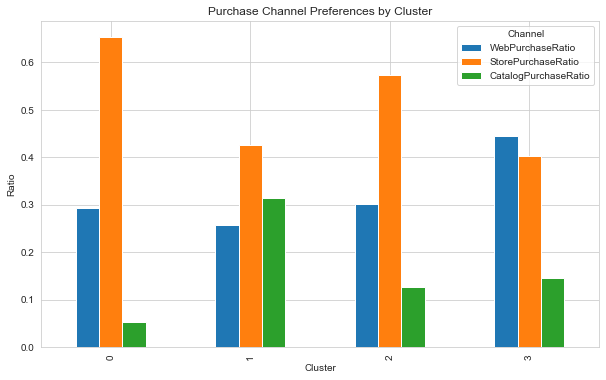

In [31]:
# Additional analysis: Purchase channel preferences by cluster
channel_means = df_clean.groupby('Cluster')[['WebPurchaseRatio', 'StorePurchaseRatio', 'CatalogPurchaseRatio']].mean()
channel_means.plot(kind='bar', figsize=(10, 6))
plt.title('Purchase Channel Preferences by Cluster')
plt.ylabel('Ratio')
plt.legend(title='Channel')
plt.show()

In [32]:
# Product category preferences by cluster
category_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
category_means = df_clean.groupby('Cluster')[category_cols].mean()

In [33]:
# Create proportional representation
for col in category_cols:
    category_means[col] = category_means[col] / category_means[category_cols].sum(axis=1)

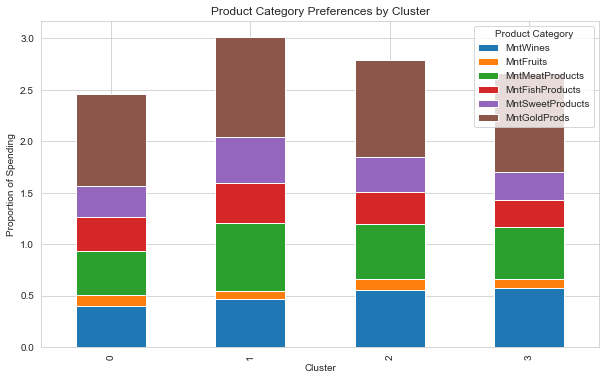

In [34]:
# Plot product preferences
category_means.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Product Category Preferences by Cluster')
plt.ylabel('Proportion of Spending')
plt.legend(title='Product Category')
plt.show()


In [35]:
# Based on the analysis, name each segment
segment_names = {
    0: "Budget Conscious Customers",  # Based on the cluster summary showing lower income & spending
    1: "High-Value Shoppers",         # Based on highest total spend and income
    2: "Mainstream Customers",        # Mid-range income and spending
    3: "Online Browsers"              # High web visits but lower spending
}

In [36]:
# Add segment names to dataframe
df_clean['Segment'] = df_clean['Cluster'].map(segment_names)

In [37]:
# Calculate cluster sizes
cluster_sizes = df_clean['Segment'].value_counts()
print("\nCluster Sizes:")
print(cluster_sizes)


Cluster Sizes:
Segment
Online Browsers               631
High-Value Shoppers           574
Mainstream Customers          547
Budget Conscious Customers    464
Name: count, dtype: int64


In [38]:
# Create a summary of key insights for each segment
print("\nKey Insights by Segment:")
for cluster in range(4):
    segment = segment_names[cluster]
    segment_data = df_clean[df_clean['Cluster'] == cluster]


Key Insights by Segment:


In [39]:
    print(f"\n{segment}:")
    print(f"- Average Age: {segment_data['Age'].mean():.1f} years")
    print(f"- Average Income: ${segment_data['Income'].mean():.2f}")
    print(f"- Average Total Spend: ${segment_data['TotalSpend'].mean():.2f}")
    print(f"- Campaign Acceptance Rate: {segment_data[campaign_cols].mean().mean()*100:.1f}%")
    print(f"- Primary Purchase Channel: {['Web', 'Store', 'Catalog'][np.argmax([segment_data['WebPurchaseRatio'].mean(), segment_data['StorePurchaseRatio'].mean(), segment_data['CatalogPurchaseRatio'].mean()])]}")


Online Browsers:
- Average Age: 56.8 years
- Average Income: $46481.10
- Average Total Spend: $497.68
- Campaign Acceptance Rate: 6.6%
- Primary Purchase Channel: Web


In [40]:
    # Top spending category
    spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
    category_names = ['Wine', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
    top_category = category_names[np.argmax([segment_data[col].mean() for col in spending_cols])]
    print(f"- Top Spending Category: {top_category}")

- Top Spending Category: Wine


# Business Recommendations

#Based on our analysis of customer segments, we recommend the following strategies:

## Segment 1: Budget Conscious Customers
- Create budget-friendly product bundles
- Develop loyalty programs with gradual benefits to encourage increased spending
- Send targeted promotions for essential items
- Avoid premium pricing strategies for this segment

## Segment 2: High-Value Shoppers

- Implement VIP loyalty program with exclusive benefits and early access to new products
- Create premium product bundles
- Develop personalized recommendations based on past purchases
- Focus marketing budget disproportionately on this high-value segment


## Segment 3: Mainstream Customers

- Create personalized offers based on purchase history
- Develop mid-tier loyalty program
- Cross-sell complementary products
- Test promotions to increase purchase frequency

## Segment 4: Online Browsers

- Optimize website UX to improve conversion rates
- Implement abandoned cart emails and retargeting
- Create special online-only promotions
- Develop a digital engagement strategy to convert browsers to buyers

## Overall Recommendations:

1. Develop segment-specific marketing campaigns tailored to each customer group
2. Allocate marketing budget proportionally to segment value
3. Create a tiered loyalty program with different benefits for each segment
4. Adjust product inventory based on segment preferences
5. Personalize email communications based on segment characteristics

# Conclusion

This customer segmentation analysis has revealed four distinct customer groups with unique characteristics, preferences, and behaviors. By understanding these segments, the retail company can now:

1. Develop more effective and targeted marketing campaigns
2. Optimize product offerings based on segment preferences
3. Create personalized loyalty programs tailored to each segment
4. Allocate resources more effectively to maximize ROI
5. Improve customer satisfaction through personalized experiences

The machine learning approach used in this analysis provides actionable insights that can directly impact business performance by increasing customer retention, enhancing marketing effectiveness, and driving revenue growth. By implementing the segment-specific strategies outlined in our recommendations, the company can build stronger, more profitable customer relationships.


# Key Insights from the Data

- There are 4 distinct customer segments with different spending patterns, income levels, and demographics
- Income is a significant predictor of spending behavior
- Wine products appear to be the highest spending category for many customers
- Campaign response rates vary significantly by segment
- Web browsing behavior doesn't always correlate with purchasing behavior
- The elbow plot suggests 4 is the optimal number of clusters

This project will help the retail company develop targeted marketing strategies and optimize their product offerings and campaigns to better serve each customer segment.